# Differential Drive Robot in Artificial Gravity

Course: AE 353: Aerospace Control Systems (Spring 2022 Session)

Authors: *Varsha Krishnakumar* and *Ajitesh Muppuru*

Version: *March 2022*

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt

# Pybullet Simulator Interface
import ae353_segbot

import importlib
import numpy as np
from scipy import linalg
from scipy import signal
import sympy as sym
importlib.reload(ae353_segbot)


<module 'ae353_segbot' from 'C:\\Users\\HP\\Documents\\GitHub\\02_segbot\\ae353_segbot.py'>

### Pybullet Simulator 

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

There are several optional arguments:

* `display` (`True` or `False`) is whether or not to show the simulation window;
* `width` and `height` (positive integers, default `640` and `480`, respectively) is the weight and height of the simulation window (if shown) in pixels;
* `bumpy` (`True` or `False`) is whether or not the station is "bumpy".

**You must evaluate this cell only *once*.** If you want to start fresh with a new simulator, you must do `Kernel -> Restart` from the notebook menu first. If you evaluate this cell more than once without a call to `Kernel -> Restart` then you may get strange behavior that is hard to debug.

In [2]:
simulator = ae353_segbot.Simulator(
    display=False,
    width=480,
    height=320,
    bumpy=True,
)

### Construction of $f$

In [3]:
# Dimensions of chassis
dx = 0.4
dy = 0.6
dz = 0.8

# Distance between axle and COM of chassis
h = 0.3

# Half-distance between wheels
a = 0.7 / 2

# Mass of chassis
mb = 12.

# MOI of chassis
Jbx = (mb / 12) * (dy**2 + dz**2)
Jby = (mb / 12) * (dx**2 + dz**2)
Jbz = (mb / 12) * (dx**2 + dy**2)

# Radius of each wheel
r = 0.325

# Width of each wheel
hw = 0.075

# Mass of each wheel
mw = 1.2

# MOI of each wheel
Jw = (mw / 2) * r**2
Jwt = (mw / 12) * (3 * r**2 + hw**2)

# Total mass
m = mb + 2 * mw

# Total MOI
Jx = Jbx + 2 * Jwt
Jy = Jby
Jz = Jbz + 2 * Jwt

# Station parameters
station_velocity = -0.5 # <-- velocity of station velocity
station_radius = 20.    # <-- radius in meters of inside surface of station

# Acceleration of artifical gravity
g = station_velocity**2 * station_radius

In [4]:
# Dimensions
h = sym.nsimplify(h)
a = sym.nsimplify(a)
r = sym.nsimplify(r)


# Masses
mb = sym.nsimplify(mb)
mw = sym.nsimplify(mw)
m = sym.nsimplify(m)

# MOIs
Jx = sym.nsimplify(Jx)
Jy = sym.nsimplify(Jy)
Jz = sym.nsimplify(Jz)
Jw = sym.nsimplify(Jw)
Jwt = sym.nsimplify(Jwt)

# Gravity
g = sym.nsimplify(g)

Define variables using SymPy

In [5]:
(e_l,
 e_h,
 v,
 w,
 theta,
 thetadot,
 tau_R,
 tau_L) = sym.symbols('e_l, e_h, v, w, theta, thetadot, tau_R, tau_L', real=True)

Compute equations of motion, excluding lateral and heading errors (see [Tuttle, 2014](https://docs.lib.purdue.edu/cgi/viewcontent.cgi?article=1415&context=open_access_theses)):

In [6]:
M = sym.Matrix([[m + 2 * Jw / r**2, 0, mb * h * sym.cos(theta)],
                [0, (Jx + mb * h**2) * sym.sin(theta)**2 + Jz * sym.cos(theta)**2 + (2 * Jw * a**2 / r**2) + 2 * mw * a**2, 0],
                [mb * h * sym.cos(theta), 0, Jy * mb * h**2]])
N = sym.Matrix([[mb * h * (w**2 + thetadot**2) * sym.sin(theta)],
                [-2 * (Jx - Jz + m * h**2) * sym.cos(theta) * sym.sin(theta) * w * thetadot - mb * h * sym.sin(theta) * v * w],
                [(Jx - Jz + mb * h**2) * sym.cos(theta) * sym.sin(theta) * w**2 + mb * g * h * sym.sin(theta)]])
R = sym.Matrix([[1 / r, 1 / r],
                [-a / r, a / r],
                [-1, -1]])
f = sym.simplify(M.inv() * (N + R * sym.Matrix([[tau_L], [tau_R]])))

Compute full equations of motion:

In [7]:
# Full equations of motion 
f = sym.Matrix([[v * sym.sin(e_h)],
                [w],
                [f]])

# Replace second-order ODE with two first-order ODEs
f = f.row_insert(4,sym.Matrix([[thetadot]]))

# Convert floating-point to rational numbers
f = sym.nsimplify(f, rational=True)
f

Matrix([
[                                                                                                                                                                           v*sin(e_h)],
[                                                                                                                                                                                    w],
[        -(1200*tau_L + 1200*tau_R + 1404*(thetadot**2 + w**2)*sin(theta) + 65*(50*tau_L + 50*tau_R - 39*w**2*sin(2*theta) - 900*sin(theta))*cos(theta)/2)/(5850*cos(theta)**2 - 6084)],
[                                                                    32*(-875*tau_L + 875*tau_R - 1443*thetadot*w*sin(2*theta) - 2925*v*w*sin(theta))/(13*(3120*sin(theta)**2 + 2051))],
[                                                                                                                                                                             thetadot],
[5*(4225*tau_L + 4225*tau_R - 6591*w**2*sin(2*theta)/2 + 30*(100*t

The function $f$ can be written as:

$$\begin{bmatrix} \dot{e}_\text{lateral} \\ \dot{e}_\text{heading} \\ \dot{v} \\ \dot{w} \\ \ddot{\theta} \\ \dot{\theta} \end{bmatrix} = f(e_\text{lateral}, e_\text{heading}, v, w, \theta, \dot{\theta}, \tau_R, \tau_L)$$

Set up A and B matrices from function $f$

In [8]:
def get_model(e_le, e_he, ve, we, thetae, thetadote, tau_Re, tau_Le):
    
    # Find A and B in symbolic form
    A_sym = f.jacobian([e_l, e_h, v, w, theta, thetadot])
    
    B_sym = f.jacobian([tau_R, tau_L])
    
    # Create lambda functions to allow numerical evaluation of A and B
    A_num = sym.lambdify([e_l, e_h, v, w, theta, thetadot, tau_R, tau_L], A_sym)
    
    B_num = sym.lambdify([e_l, e_h, v, w, theta, thetadot, tau_R, tau_L], B_sym)
    
    # Find A and B in numeric form (making sure the result is floating-point)
    A = A_num(e_le, e_he, ve, we, thetae, thetadote, tau_Re, tau_Le).astype(float)
    
    B = B_num(e_le, e_he, ve, we, thetae, thetadote, tau_Re, tau_Le).astype(float)
    
    return A, B


Define a controller that maps sensor measurements to actuator commands. By default, it chooses to apply zero torque to the segbot. 

In [9]:
class Controller:
    def __init__(self, K, e_le, e_he, ve, we, thetae, thetadote, tau_Re, tau_Le):
        self.K = K
        self.e_le = e_le
        self.e_he = e_he
        self.ve = ve
        self.we = we
        self.thetae = thetae
        self.thetadote = thetadote
        self.tau_Re = tau_Re
        self.tau_Le = tau_Le
        pass
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            lateral_error,
            heading_error,
            forward_speed,
            turning_rate,
            pitch_angle,
            pitch_rate,
        ):
        
        # FIXME: replace the following lines
        x = np.array([lateral_error - self.e_le, heading_error - self.e_he, forward_speed - self.ve, turning_rate - self.we, pitch_angle - self.thetae, pitch_rate - self.thetadote])
        u = -self.K@x
        tau_R = u[0]
        tau_L = u[1]
        right_wheel_torque = tau_R
        left_wheel_torque = tau_L
        
        return right_wheel_torque, left_wheel_torque

Define a function that obtains relevant data from trial robot runs utilizing features of the Controller Class

In [10]:
def get_data(
    simulator, 
    e_le,
    e_he,
    ve,
    we,
    thetae,
    thetadote,
    tau_Re,
    tau_Le,
    K,
    vi, 
    e_li, 
    e_hi, 
    thetai, 
    svi,
    max_time=600.0
):
    
    # Assign instance of the Controller Class
    controller = Controller(
        K,
        e_le,
        e_he,
        ve,
        we,
        thetae,
        thetadote,
        tau_Re,
        tau_Le
    )

    # Reset simulator with initial conditions 
    simulator.reset(
        initial_speed=vi, 
        initial_lateral_error=e_li, 
        initial_heading_error=e_hi,
        initial_pitch=thetai,
        station_velocity=svi 
    )


    # Reset controller
    controller.reset()
    
    # Choose a camera view: [ camera_sideview(), camera_backview(), camera_wideview() ]
    simulator.camera_backview()

    # Run simulator
    data = simulator.run(
        controller,           # <-- required (an instance of your Controller class)
        max_time=max_time,    # <-- optional (how long you want to run the simulation in seconds)
        data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
        video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
    )

    # Return data
    return data

With chosen equilibrium conditions, modify *f* with relevant values

In [11]:
e_le= 0.0
e_he = 0.0
ve = 1.2
thetae = 0.
thetadote = 0.
we = 0.
v2e = 0.
tau_Re = 0.
tau_Le = 0.


f_num = sym.lambdify([e_l, e_h, w, theta, thetadot, tau_R, tau_L], f)
f_eq = f_num(e_le, e_he, we, thetae, thetadote, tau_Re, tau_Le)

# Convert numerical array from type 'object' to floats
f_eq = np.array(f_eq).astype(np.float64)

# raise exception if f != 0
if not np.allclose(f_eq, 0.):
    raise Exception('equilibrium point is invalid')


Assign matrices A and B with equilibrium conditions

In [12]:
A, B = get_model(
    e_le,
    e_he,
    ve,
    we,
    thetae,
    thetadote,
    tau_Re,
    tau_Le
)

Set up initial conditions

In [35]:
# Initial conditions (modifiable)
vi = 1.0
e_li = 0.
e_hi = 0.
thetai = -0.
svi = -0.5

### Define a function for generating set of Q and R matrices
Simulate Q and R matrices for testing purposes

In [14]:
'''
Input variables:
    end: Maximum limit for q1 weight in Q matrix
    num: Desired number of Q and R matrices to generate
    
Output variables:
    Q_list: List of Q matrices (size 6 x 6) 
    R_list: List of R matrices (size 2 x 2)
'''

def generate_lqrmatrices(end, num):
    Q_list = []
    R_list = []
    q1 = np.linspace(1000, end, num)
    q2 = np.linspace(0.1, 500, num)
    q3 = np.linspace(0.1, 1, num)
    q4 = np.linspace(0.1, 1, num)
    q5 = np.linspace(0.1, 1, num)
    q6 = np.linspace(0.1, 5, num)
    r1 = np.linspace(0.1, 2, num)
    r3 = np.linspace(0.1, 2, num)
    for i in range(0,len(q1)):
        Q = np.diag([q1[i], q2[i], q3[i],q4[i], q5[i], q6[i]])
        Q_list.append(Q)
        R = np.diag([r1[i], r3[i]])
        R_list.append(R)
    
    return Q_list, R_list

Q_list, R_list = generate_lqrmatrices(10000, 20)

### Define a function for generating gain matrices from Q and R matrices

Simulate K matrices from generate_lqrmatrices() function for testing purposes

In [14]:
'''
Input variables:
    Q_list: List of Q matrices (size 6 x 6) 
    R_list: List of R matrices (size 2 x 2)
    
Output variables:
    K_working: List of K matrices that produce results in accordance with segbot requirements
    final_Q: List of efficient Q matrices
    final_R: List of efficient R matrices
'''

def generate_gains(Q_list, R_list):
    K_list = []   # total K list
    K_working = [] # K list that satisfies requirements
    P_list = []
    theta = []
    heading = []
    lateral = []
    velocity = []
    final_Q = []  # Q matrices corresponding to K_working
    final_R = []  # R matrices corresponding to K_working
    for i in range(0, len(Q_list)):
        P_list.append(linalg.solve_continuous_are(A, B, Q_list[i], R_list[i]))
        K_list.append((linalg.inv(R_list[i]) @ B.T @ P_list[i]))
        data = get_data(simulator, e_le, e_he, ve, we, thetae, thetadote, tau_Re,tau_Le, K_list[i], vi,e_li, e_hi,thetai,svi,max_time=50.0)
        theta.append(data['pitch_angle'])
        heading.append(data['heading_error'])
        lateral.append(data['lateral_error'])
        velocity.append(data['forward_speed'])
        
        if (np.all(velocity[i]) > 0.8) == True:
            if ((np.all(theta[i]) < 0.1) and (np.all(heading[i]) < 0.1) and (np.all(lateral[i]) < 0.1)) == True:
                K_working.append(K_list[i])
                final_Q.append(Q_list[i])
                final_R.append(R_list[i])
            
    return [K_working, final_Q, final_R]

K, Q, R = generate_gains(Q_list, R_list)


Write K, Q, R results from generate_lqrmatrices() and generate_gains() to txt file

In [45]:
# Standard write to file function
# def write_to_file(K, Q, R):
#     file1 = open("lqr.txt","w")
#     L = [K, Q, R] 
#     file1.writelines(L)
#     file1.close()

# write_to_file(K, Q, R)

Set up K, Q, and R matrices for Segbot analysis

In [36]:
# Selected K and lqr matrices

K = np.array([[ 50.06920419,  27.18452469,  -0.50069204,   5.11245109,
          -10.80516975,  -1.33059646],
         [-50.06920419, -27.18452469,  -0.50069204,  -5.11245109,
          -10.80516975,  -1.33059646]])
Q = np.array([[7.63157895e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 3.68447368e+02, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 7.63157895e-01, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.63157895e-01,
          0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          7.63157895e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 3.71052632e+00]])

R = np.array([[1.5, 0. ],
         [0. , 1.5]])


Run the simulator.

In [43]:
data = get_data(simulator, e_le, e_he, ve, we, thetae, thetadote, tau_Re,tau_Le, K, vi,e_li, e_hi,thetai,svi,max_time=60.0)

Get, show, and save a snapshot of the simulation after the last time step.

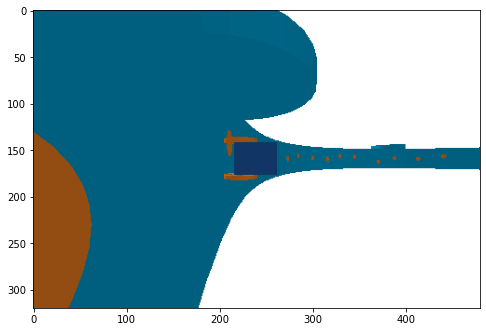

In [42]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results.

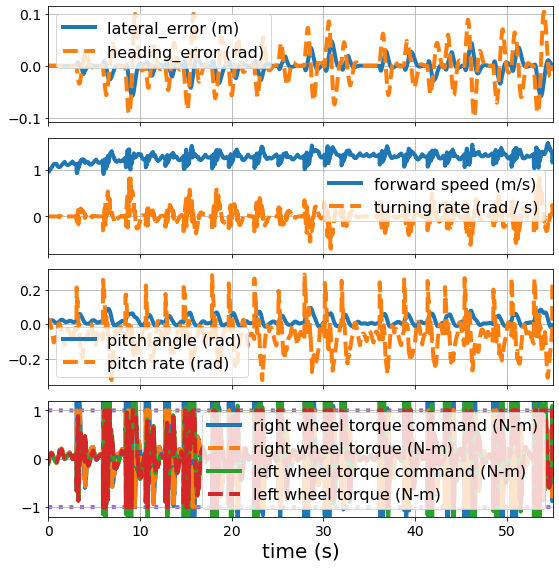

In [18]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_pos, ax_vel, ax_pitch, ax_torque) = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

# Plot lateral and heading error
ax_pos.plot(
    data['t'], data['lateral_error'],
    label='lateral_error (m)', linewidth=4,
)
ax_pos.plot(
    data['t'], data['heading_error'],
    '--', label='heading_error (rad)', linewidth=4,
)
ax_pos.grid()
ax_pos.legend(fontsize=16)
ax_pos.tick_params(labelsize=14)

# Plot forward speed and turning rate
ax_vel.plot(
    data['t'], data['forward_speed'],
    label='forward speed (m/s)', linewidth=4,
)
ax_vel.plot(
    data['t'], data['turning_rate'],
    '--', label='turning rate (rad / s)', linewidth=4,
)
ax_vel.grid()
ax_vel.legend(fontsize=16)
ax_vel.tick_params(labelsize=14)

# Plot pitch angle and pitch rate
ax_pitch.plot(
    data['t'], data['pitch_angle'],
    label='pitch angle (rad)', linewidth=4,
)
ax_pitch.plot(
    data['t'], data['pitch_rate'],
    '--', label='pitch rate (rad)', linewidth=4,
)
ax_pitch.grid()
ax_pitch.legend(fontsize=16)
ax_pitch.tick_params(labelsize=14)

# Plot torques
ax_torque.plot(
    data['t'], data['right_wheel_torque_command'],
    label='right wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['right_wheel_torque'],
    '--', label='right wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque_command'],
    label='left wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque'],
    '--', label='left wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=16)
ax_torque.tick_params(labelsize=14)
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

Save the figure (without transparent background).

In [ ]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)

### Initial Conditions: Testing

Set up ranges for initial conditions for forward velocity (m/s) and pitch angle (rad)

In [ ]:
velocity_range = [-3, -2, -1, -0.5, 0, 0.5, 1, 2, 3]
theta_range = [thetae - 1, thetae - 0.8, thetae - 0.5, thetae, thetae + 0.5, thetae + 0.8, thetae + 1]


# Initial Velocity conditions
v1i = get_data(simulator, e_le, e_he, ve, we, thetae, thetadote, tau_Re,tau_Le, K, velocity_range[0],e_li, e_hi,thetai,svi,max_time=20.0)
v2i = get_data(simulator, e_le, e_he, ve, we, thetae, thetadote, tau_Re,tau_Le, K, velocity_range[1],e_li, e_hi,thetai,svi,max_time=20.0)
v3i = get_data(simulator, e_le, e_he, ve, we, thetae, thetadote, tau_Re,tau_Le, K, velocity_range[2],e_li, e_hi,thetai,svi,max_time=20.0)
v4i = get_data(simulator, e_le, e_he, ve, we, thetae, thetadote, tau_Re,tau_Le, K, velocity_range[3],e_li, e_hi,thetai,svi,max_time=20.0)
v5i = get_data(simulator, e_le, e_he, ve, we, thetae, thetadote, tau_Re,tau_Le, K, velocity_range[4],e_li, e_hi,thetai,svi,max_time=20.0)
v6i = get_data(simulator, e_le, e_he, ve, we, thetae, thetadote, tau_Re,tau_Le, K, velocity_range[5],e_li, e_hi,thetai,svi,max_time=20.0)
v7i = get_data(simulator, e_le, e_he, ve, we, thetae, thetadote, tau_Re,tau_Le, K, velocity_range[6],e_li, e_hi,thetai,svi,max_time=20.0)
v8i = get_data(simulator, e_le, e_he, ve, we, thetae, thetadote, tau_Re,tau_Le, K, velocity_range[7],e_li, e_hi,thetai,svi,max_time=20.0)
v9i = get_data(simulator, e_le, e_he, ve, we, thetae, thetadote, tau_Re,tau_Le, K, velocity_range[8],e_li, e_hi,thetai,svi,max_time=20.0)

# Initial Pitch Angle Conditions
t1i = get_data(simulator, e_le, e_he, ve, we, thetae, thetadote, tau_Re,tau_Le, K, vi,e_li, e_hi,theta_range[0],svi,max_time=20.0)
t2i = get_data(simulator, e_le, e_he, ve, we, thetae, thetadote, tau_Re,tau_Le, K, vi,e_li, e_hi,theta_range[1],svi,max_time=20.0)
t3i = get_data(simulator, e_le, e_he, ve, we, thetae, thetadote, tau_Re,tau_Le, K, vi,e_li, e_hi,theta_range[2],svi,max_time=20.0)
t4i = get_data(simulator, e_le, e_he, ve, we, thetae, thetadote, tau_Re,tau_Le, K, vi,e_li, e_hi,theta_range[3],svi,max_time=20.0)
t5i = get_data(simulator, e_le, e_he, ve, we, thetae, thetadote, tau_Re,tau_Le, K, vi,e_li, e_hi,theta_range[4],svi,max_time=20.0)
t6i = get_data(simulator, e_le, e_he, ve, we, thetae, thetadote, tau_Re,tau_Le, K, vi,e_li, e_hi,theta_range[5],svi,max_time=20.0)
t7i = get_data(simulator, e_le, e_he, ve, we, thetae, thetadote, tau_Re,tau_Le, K, vi,e_li, e_hi,theta_range[6],svi,max_time=20.0)

Set up plot for lateral error (m) data

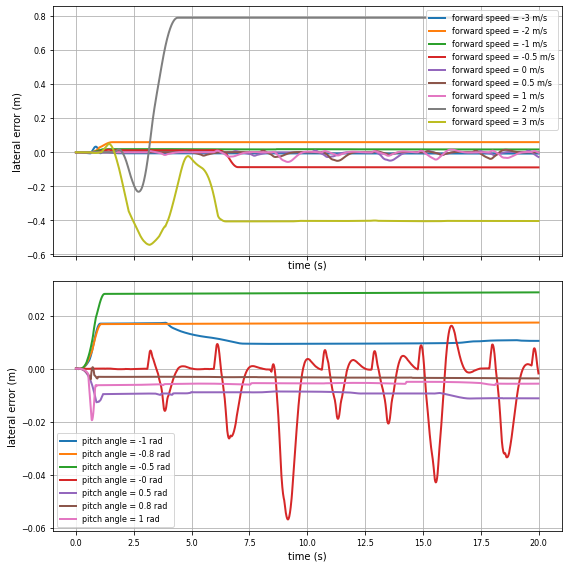

In [31]:
fig, (in_vel, in_pitch) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
               
in_vel.plot(v1i['t'], v1i['lateral_error'],
    label='forward speed = -3 m/s', linewidth=2)
in_vel.plot(v2i['t'], v2i['lateral_error'],
    label='forward speed = -2 m/s', linewidth=2)
in_vel.plot(v3i['t'], v3i['lateral_error'],
    label='forward speed = -1 m/s', linewidth=2)
in_vel.plot(v4i['t'], v4i['lateral_error'],
    label='forward speed = -0.5 m/s', linewidth=2)
in_vel.plot(v5i['t'], v5i['lateral_error'],
    label='forward speed = 0 m/s', linewidth=2)
in_vel.plot(v6i['t'], v6i['lateral_error'],
    label='forward speed = 0.5 m/s', linewidth=2)
in_vel.plot(v7i['t'], v7i['lateral_error'],
    label='forward speed = 1 m/s', linewidth=2)
in_vel.plot(v8i['t'], v8i['lateral_error'],
    label='forward speed = 2 m/s', linewidth=2)
in_vel.plot(v9i['t'], v9i['lateral_error'],
    label='forward speed = 3 m/s', linewidth=2)

in_vel.grid(True)
in_vel.legend(fontsize=8, loc = "upper right")
in_vel.tick_params(labelsize=8)
in_vel.set_ylabel('lateral error (m)')
in_vel.set_xlabel('time (s)')

in_pitch.plot(t1i['t'], t1i['lateral_error'],
    label='pitch angle = -1 rad', linewidth=2)
in_pitch.plot(t2i['t'], t2i['lateral_error'],
    label='pitch angle = -0.8 rad', linewidth=2)
in_pitch.plot(t3i['t'], t3i['lateral_error'],
    label='pitch angle = -0.5 rad', linewidth=2)
in_pitch.plot(t4i['t'], t4i['lateral_error'],
    label='pitch angle = -0 rad', linewidth=2)
in_pitch.plot(t5i['t'], t5i['lateral_error'],
    label='pitch angle = 0.5 rad', linewidth=2)
in_pitch.plot(t6i['t'], t6i['lateral_error'],
    label='pitch angle = 0.8 rad', linewidth=2)
in_pitch.plot(t7i['t'], t7i['lateral_error'],
    label='pitch angle = 1 rad', linewidth=2)

in_pitch.grid(True)
in_pitch.legend(fontsize=8, loc = "lower left")
in_pitch.tick_params(labelsize=8)
in_pitch.set_ylabel('lateral error (m)')
in_pitch.set_xlabel('time (s)')


fig.tight_layout()

Set up plot for pitch angle (rad) data

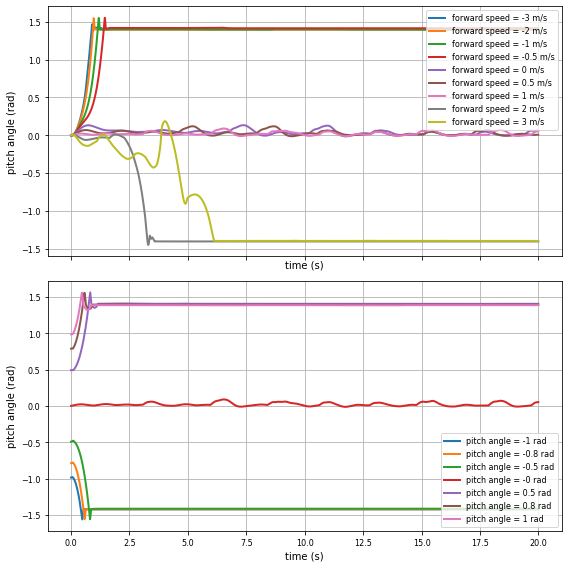

In [30]:
fig, (in_vela, in_pitcha) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)


in_vela.plot(v1i['t'], v1i['pitch_angle'],
    label='forward speed = -3 m/s', linewidth=2)
in_vela.plot(v2i['t'], v2i['pitch_angle'],
    label='forward speed = -2 m/s', linewidth=2)
in_vela.plot(v3i['t'], v3i['pitch_angle'],
    label='forward speed = -1 m/s', linewidth=2)
in_vela.plot(v4i['t'], v4i['pitch_angle'],
    label='forward speed = -0.5 m/s', linewidth=2)
in_vela.plot(v5i['t'], v5i['pitch_angle'],
    label='forward speed = 0 m/s', linewidth=2)
in_vela.plot(v6i['t'], v6i['pitch_angle'],
    label='forward speed = 0.5 m/s', linewidth=2)
in_vela.plot(v7i['t'], v7i['pitch_angle'],
    label='forward speed = 1 m/s', linewidth=2)
in_vela.plot(v8i['t'], v8i['pitch_angle'],
    label='forward speed = 2 m/s', linewidth=2)
in_vela.plot(v9i['t'], v9i['pitch_angle'],
    label='forward speed = 3 m/s', linewidth=2)

in_vela.grid(True)
in_vela.legend(fontsize=8, loc = "upper right")
in_vela.tick_params(labelsize=8)
in_vela.set_ylabel('pitch angle (rad)')
in_vela.set_xlabel('time (s)')

in_pitcha.plot(t1i['t'], t1i['pitch_angle'],
    label='pitch angle = -1 rad', linewidth=2)
in_pitcha.plot(t2i['t'], t2i['pitch_angle'],
    label='pitch angle = -0.8 rad', linewidth=2)
in_pitcha.plot(t3i['t'], t3i['pitch_angle'],
    label='pitch angle = -0.5 rad', linewidth=2)
in_pitcha.plot(t4i['t'], t4i['pitch_angle'],
    label='pitch angle = -0 rad', linewidth=2)
in_pitcha.plot(t5i['t'], t5i['pitch_angle'],
    label='pitch angle = 0.5 rad', linewidth=2)
in_pitcha.plot(t6i['t'], t6i['pitch_angle'],
    label='pitch angle = 0.8 rad', linewidth=2)
in_pitcha.plot(t7i['t'], t7i['pitch_angle'],
    label='pitch angle = 1 rad', linewidth=2)

in_pitcha.grid(True)
in_pitcha.legend(fontsize=8, loc = "lower right")
in_pitcha.tick_params(labelsize=8)
in_pitcha.set_ylabel('pitch angle (rad)')
in_pitcha.set_xlabel('time (s)')

fig.tight_layout()